In [16]:
import numpy as np
import matplotlib.pyplot as plt 
import pystan

%matplotlib inline

In [75]:
gwp_code = """
data {
    int<lower=1> N;    //time steps
    int<lower=1> D;    //dimension(V) DxD
    int<lower=1> nu;   //degrees of freedom
    matrix[D,D] L;     //cholesky decomposition of V
    vector[D] dat[N];
    real t[N];
}
parameters {
    vector[N] Z[D, nu];      //Z~N(0,1) -> U=L_K*Z 
    real<lower=0> theta;     //kernel parameter for the gaussian process  
}
transformed parameters {
    matrix[D, D] S[N];          //fitted covariance matrix
    real log_lik = 0;
    
    {
        matrix[D, nu] U[N];      //each U[N] is a gaussian process
        matrix[N, N] K;          //kernel matrix
        matrix[N, N] L_K;        //cholesky decomposition of K

        for (i in 1:N)
            for (j in 1:N)
                K[i,j] = exp(-0.5* pow(fabs(t[i]-t[j])/theta, 1) );
                
        //K = cov_exp_quad(t, 1.0, theta);   //kernel function for U
                                           //diagonal will be overwritten
        for (i in 1:N)
            K[i,i] = 1.001;
        L_K = cholesky_decompose(K);

        for (d in 1:D)
            for (i in 1:nu)
                U[,d,i] = to_array_1d(L_K*Z[d,i]);

        for (n in 1:N)
            S[n] = tcrossprod(L*U[n]);     //S = LU(LU)^T
    }
        
}
model {
    theta ~ normal(0,5);    //prior on lengthscale
    
    for (d in 1:D){
       for (i in 1:nu){
           Z[d,i] ~ normal(0, 1);   //GP prior
        }
    }
    
    for (n in 1:N)
        dat[n] ~ multi_normal(rep_vector(0, D), S[n]);
}
"""

stan_model = pystan.StanModel(model_code = gwp_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd426b630fbebcbf9f5a5d454ca0c567 NOW.


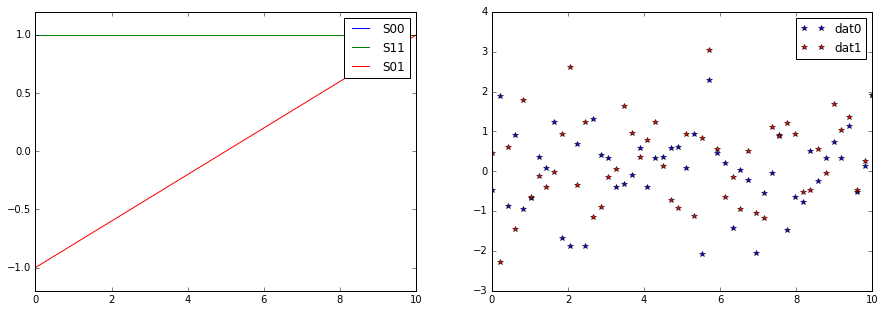

In [72]:
N = 50
D = 2
nu = 3

t_start = 0
t_end = 10
t = np.linspace(t_start, t_end, N)

V = np.array([ [1., 0.], [0., 1.] ])
L = np.linalg.cholesky(V)


#S = np.array([ [[1., 0.5*np.sin(t_)], [0.5*np.sin(t_), 1.]] for t_ in t])
S = np.array([ [[1., -1.+2.*t_/(t_end-t_start)], [-1.+2.*t_/(t_end-t_start), 1.]] for t_ in t])

dat = np.array([ np.random.multivariate_normal(np.zeros(D), S_) for S_ in S ])

#plot data
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1,2,1)
ax.plot(t, S[:,0,0], label="S00")
ax.plot(t, S[:,1,1], label="S11")
ax.plot(t, S[:,0,1], label="S01")
ax.legend()
ax.set_ylim([-1.2,1.2])

ax = fig.add_subplot(1,2,2)
ax.plot(t, dat[:,0], "b*", label="dat0")
ax.plot(t, dat[:,1], "r*", label="dat1")
ax.legend()

plt.show()

In [ ]:
parameter_dict = {'N': N, 'D': D, 'nu': nu, 'L':L, 'dat':dat, 't':t}
fit = stan_model.sampling(data = parameter_dict)

In [26]:
fit.extract(['theta'])['theta'].mean()

7.9810224405464476

In [48]:
S_fit = fit.extract(['S'])['S']
theta_fit = fit.extract(['theta'])['theta']

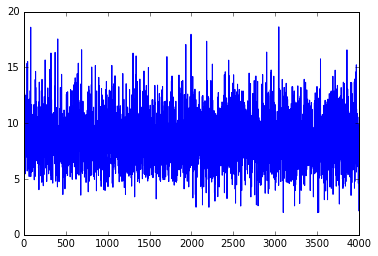

In [49]:
plt.plot(theta_fit)

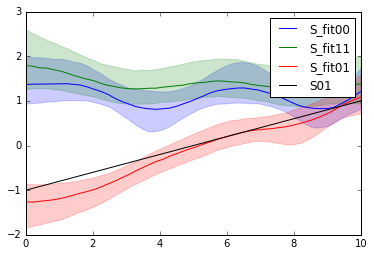

In [74]:
S_fit = fit.extract('S')['S']
S_fit_mean = S_fit.mean(axis=0)
S_fit_median = np.percentile(S_fit, 50, axis=0)
S_fit_top = np.percentile(S_fit, 80, axis=0)
S_fit_bot = np.percentile(S_fit, 20, axis=0)

fig = plt.figure()
plt.plot(t, S_fit_median[:,0,0], 'b', label="S_fit00")
plt.fill_between(t, S_fit_top[:,0,0], S_fit_bot[:,0,0], color='b',  alpha=0.2)
plt.plot(t, S_fit_median[:,1,1], 'g', label="S_fit11")
plt.fill_between(t, S_fit_top[:,1,1], S_fit_bot[:,1,1], color='g',  alpha=0.2)
plt.plot(t, S_fit_median[:,0,1], 'r', label="S_fit01")
plt.fill_between(t, S_fit_top[:,0,1], S_fit_bot[:,0,1], color='r',  alpha=0.2)
plt.plot(t, S[:,0,1], color='black', label="S01")
plt.legend()
plt.show()

/home/nirwan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  


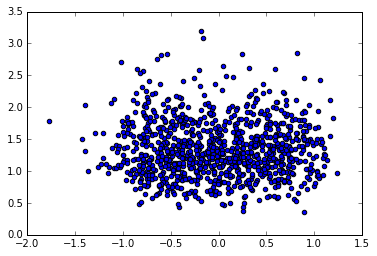

In [65]:
fit.get_sampler_params(inc_warmup=False)
theta_fit = fit.extract(['theta'], permuted=False, inc_warmup=False)
theta_fit.shape
# plt.plot(theta_fit[:,0,1])
plt.scatter(theta_fit[:,0,0], theta_fit[:,0,1000])

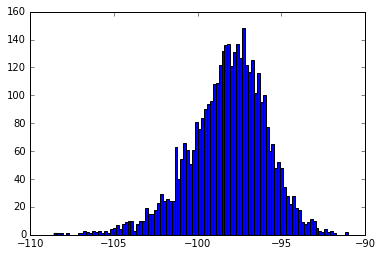

In [15]:
_ = plt.hist(fit.extract("log_lik")['log_lik'], bins=100)